In [18]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import networkx as nx
import hypernetx.algorithms.hypergraph_modularity as hmod
import pandas as pd
import igraph as ig
import hypernetx as hnx
import statistics
import itertools
import math
import community ## package python-louvain
import random
import pickle
from itertools import combinations
from PyComplexHeatmap import *

# Functions

In [98]:
## flatten lists
def flatten(l):
    return [item for sublist in l for item in sublist]
    
## Calculate bounded weight per read
## mathematically, W = (skip + 1) * (1-lengthFreq)/((consec + 1) * card)

def bounded_lengthFreq(binList):
    rCard = binList.count(1)
    ixFirst = binList.index(1)
    ixLast = (len(binList) - 1) - binList[::-1].index(1)    ## Index base 0
    concatemerLen = ixLast - ixFirst + 1 
    try:
        lGC = freqLenPerCard[rCard][concatemerLen]
    except KeyError:
        lGC = 0
    consecBinCounts = sum([binList[i:i+2]==[1,1] for i in range(len(binList)-1)])
    skip = (rCard - consecBinCounts - 1)
    score = ((skip + 1) * (1-lGC))/ ((consecBinCounts + 1) * rCard)
    return(score)

## Convert incidence matrix to 2d hiC matrix
def makeHiC_fromInc(incDF):
    nrow = incDF.shape[0]
    ncol = incDF.shape[1]
    binIDs = list(incDF.index)
    df = pd.DataFrame(np.zeros(shape = (nrow,nrow)), index=binIDs, columns=binIDs)
    for read in incDF.columns:
        arr = incDF[read][incDF[read] == 1].index
        for a in arr:
            df.loc[a][a] += 1
        combs = list(combinations(arr,2))
        for c in combs:
            df.loc[c[0]][c[1]] += 1
            df.loc[c[1]][c[0]] += 1
    return(df)

## 2D HiC matrix with counts normalized by weights
def makeNorm_HiC_fromInc(incDF,weightList):
    nrow = incDF.shape[0]
    ncol = incDF.shape[1]
    binIDs = list(incDF.index)
    df = pd.DataFrame(np.zeros(shape = (nrow,nrow)), index=binIDs, columns=binIDs)
    for read in incDF.columns:
        arr = incDF[read][incDF[read] == 1].index
        for a in arr:
            df.loc[a][a] += float(1/len(arr))
        combs = list(combinations(arr,2))
        for c in combs:
            df.loc[c[0]][c[1]] += weightList[read]
            df.loc[c[1]][c[0]] += weightList[read]
    return(df)


def compareClusteringMethods(hg,K):
    HG = hmod.precompute_attributes(hg)
    rand_qh = randomPartition(hg,HG,K)
    kumarClusters = kumarAlg(HG,K)
    print(kumarClusters)
    louvainClusters = twoSectionAndLouvain(HG,K)
    print(louvainClusters)
    return([rand_qh,kumarClusters,louvainClusters])

def randomPartition(hg,HG,K):
    ## random
    V = list(hg.nodes)
    p = np.random.choice(K, size=len(V))
    RandPart = hmod.dict2part({V[i]:p[i] for i in range(len(V))})
    rand_qh = hmod.modularity(HG, RandPart)
    print(K," random clusters, qH = ",rand_qh)
    return(rand_qh)

def twoSectionAndLouvain(HG,K):
    ## 2-section and louvain
    G = hmod.two_section(HG)
    ## Louvain algorithm
    G.vs['louvain'] = G.community_multilevel(weights='weight').membership
    ml = hmod.dict2part({v['name']:v['louvain'] for v in G.vs})
    print("Num 2-section Louvain clusters = ",len(ml))
    print('Louvain qH =',hmod.modularity(HG, ml))
    return(ml)
    
def kumarAlg(HG,K):
    ## kumar
    kumarPart = hmod.kumar(HG)
    print("Num kumar clusters = ",len(kumarPart))
    print('Kumar qH =',hmod.modularity(HG, kumarPart))
    return(kumarPart)


# Read and process input

In [3]:
## get intra-chromosomal genes

dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v1_poreC_explore/'
chromSizes = pd.read_csv(f'{dataDir}hg38.chromSizes',sep="\t", names = ['chr','size']).set_index('chr')['size'].to_dict()
readConcatemersWClosestGene = f'{dataDir}NlaIII_GM12878_output_byChr/NlaIII_GM12878_chr19.gz'
colnames = ["chr","start","end","readID","readLen","readQual",
"geneChr","geneStart","geneEnd","strand","geneID","bioType","geneName","dist","ID"]

fullBed = pd.read_csv(readConcatemersWClosestGene,sep = "\t",names = colnames)

## Get frequency of length distributions given cardinality
with open(f'{dataDir}../v0_hypergraphSimulations/freqLensGivenCard.pkl', 'rb') as pickle_file:
    freqLenPerCard = pickle.load(pickle_file)

global freqLenPerCard

In [4]:
## Add bin ID
chr19 = fullBed[fullBed['chr']=="chr19"]
binSize = 5*10**5
chrBins = [x for x in range(0,chromSizes['chr19']+binSize,binSize)]
chr19_binned = pd.cut(chr19['start'],bins = chrBins, labels = ["Bin_"+str(i+1) for i in range(len(chrBins)-1)]).rename("binID")
chr19_wBinID = chr19.merge(chr19_binned,left_index=True,right_index=True)

### Subsample reads for code testing

In [76]:
random.seed(123)
randomReadIdx = random.sample(list(chr19_wBinID['ID']),5*10**5)
subsetDF = chr19_wBinID[chr19_wBinID['ID'].isin(randomReadIdx)]
print(subsetDF.shape)
chr19IncDF = pd.pivot_table(data=subsetDF[['ID', 'binID']], index='binID', columns='ID', aggfunc=lambda x: 1, fill_value=0)
print(chr19IncDF.shape)

(1562849, 16)
(114, 467183)


In [77]:
colSums_chr19IncDF = chr19IncDF.sum()
intraChrom19 = chr19IncDF.loc[:, colSums_chr19IncDF >=2]
intraChrom19.shape

(114, 240225)

In [78]:
ic19_full = hnx.Hypergraph.from_incidence_dataframe(intraChrom19)
weights = pd.Series([bounded_lengthFreq(list(intraChrom19[c])) for c in intraChrom19.columns], index=intraChrom19.columns)
print(ic19_full.number_of_nodes())
print(ic19_full.number_of_edges())

114
240225


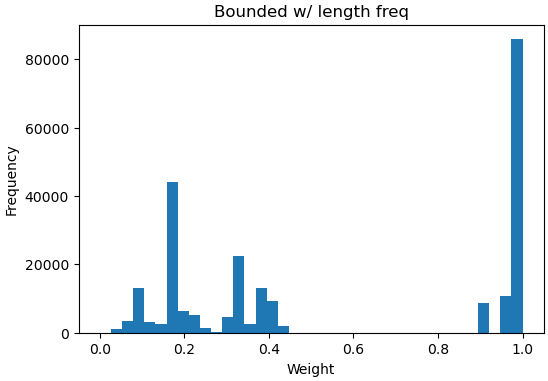

In [79]:
# Generate a histogram
plt.figure(figsize=(6,4))
plt.hist(weights, bins='auto')

# Add labels and title
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Bounded w/ length freq')

# Display the histogram
plt.show()

In [80]:
chrom19_hiC = makeHiC_fromInc(intraChrom19)
chrom19_normHiC = makeNorm_HiC_fromInc(intraChrom19,weights)

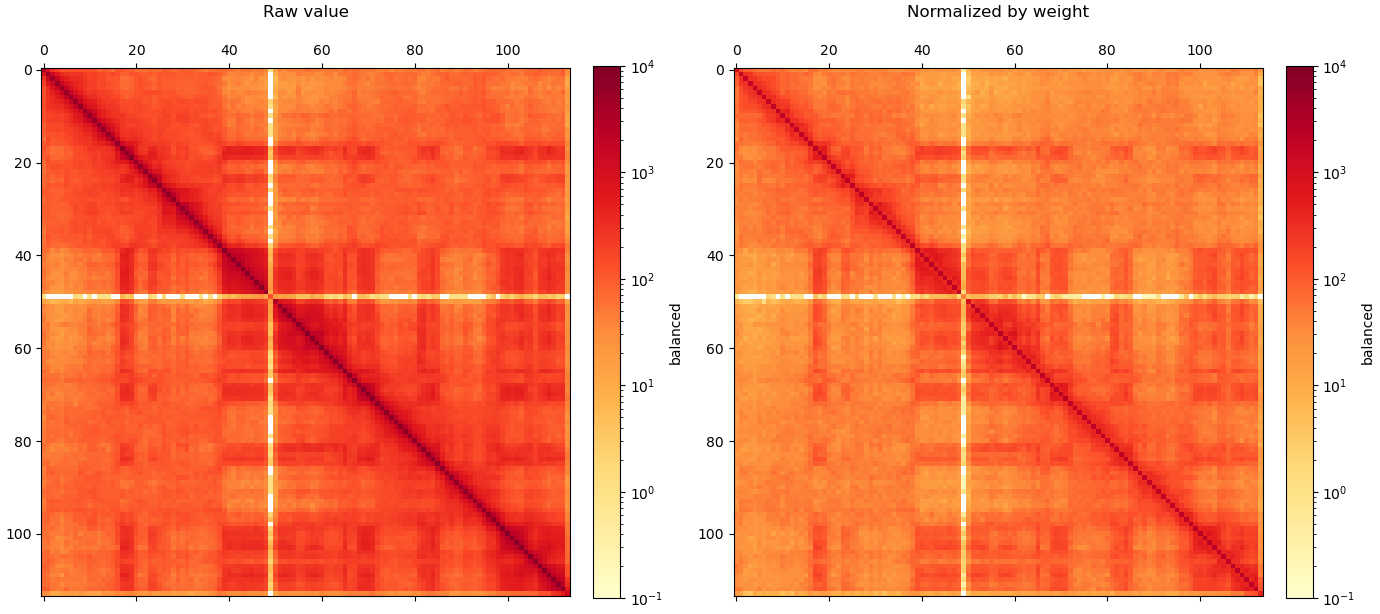

In [83]:
from matplotlib.colors import LogNorm

f, axs = plt.subplots(
    figsize=(14,7),
    ncols=2, nrows = 1)

ax = axs[0]
im = ax.matshow(
    chrom19_hiC,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4, vmin = 0.1)
)
ax.set_title("Raw value", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

ax = axs[1]
im = ax.matshow(
    chrom19_normHiC,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4,vmin = 0.1)
)
ax.set_title("Normalized by weight", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

plt.tight_layout()
plt.show()

In [84]:
for e in ic19_full.edges:
    ic19_full.edges[e].weight = weights[e]
rand_qh_pI_BLF, kumClust_pI_BLF, louClust_pI_BLF = compareClusteringMethods(ic19_full,K = 10)

10  random clusters, qH =  -0.0007667983345326507
Num kumar clusters =  5
Kumar qH = 0.2916291878521191
[{'Bin_4', 'Bin_5', 'Bin_15', 'Bin_26', 'Bin_24', 'Bin_38', 'Bin_36', 'Bin_23', 'Bin_29', 'Bin_8', 'Bin_10', 'Bin_30', 'Bin_35', 'Bin_28', 'Bin_33', 'Bin_11', 'Bin_16', 'Bin_3', 'Bin_31', 'Bin_21', 'Bin_37', 'Bin_2', 'Bin_34', 'Bin_12', 'Bin_32', 'Bin_1', 'Bin_17', 'Bin_9', 'Bin_6', 'Bin_13', 'Bin_7', 'Bin_27', 'Bin_22', 'Bin_39', 'Bin_14', 'Bin_25'}, {'Bin_19', 'Bin_41', 'Bin_48', 'Bin_49', 'Bin_20', 'Bin_46', 'Bin_42', 'Bin_45', 'Bin_40', 'Bin_18', 'Bin_47', 'Bin_44', 'Bin_43'}, {'Bin_73', 'Bin_55', 'Bin_57', 'Bin_71', 'Bin_50', 'Bin_63', 'Bin_60', 'Bin_59', 'Bin_74', 'Bin_70', 'Bin_64', 'Bin_76', 'Bin_69', 'Bin_75', 'Bin_67', 'Bin_62', 'Bin_65', 'Bin_66', 'Bin_61', 'Bin_72', 'Bin_68', 'Bin_56', 'Bin_58'}, {'Bin_78', 'Bin_90', 'Bin_86', 'Bin_81', 'Bin_80', 'Bin_83', 'Bin_77', 'Bin_88', 'Bin_101', 'Bin_95', 'Bin_103', 'Bin_91', 'Bin_100', 'Bin_92', 'Bin_82', 'Bin_85', 'Bin_93', 'Bin

In [146]:
clusterSizes = [len(item) for item in kumClust_pI_BLF]
clusterIDs = flatten([[i]*clusterSizes[i] for i in range(len(clusterSizes))])
kumClusters = flatten([list(item) for item in kumClust_pI_BLF])
orderedClustIDs= [clusterIDs[kumClusters.index(bID)] for bID in chrom19_normHiC.columns]

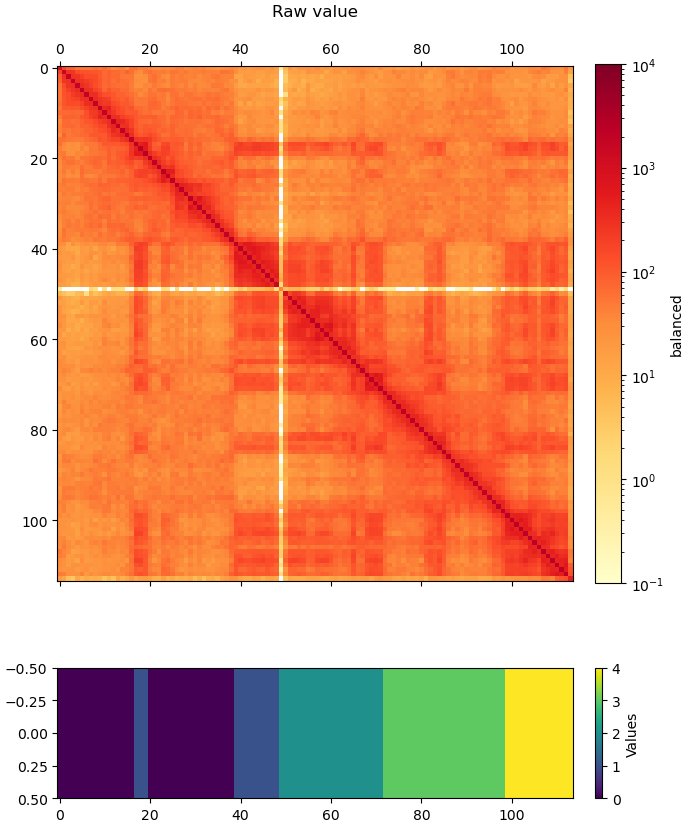

In [163]:
f, axs = plt.subplots(
    figsize=(7,9),
    ncols=1, nrows = 2,
    gridspec_kw={'height_ratios': [1, 0.2]})

ax = axs[0]
im = ax.matshow(
    chrom19_normHiC,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4, vmin = 0.1)
)
ax.set_title("Raw value", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

ax = axs[1]
im = ax.imshow(np.array([orderedClustIDs]), cmap="viridis", aspect="auto")
# Add colorbar to show legend
cbar = plt.colorbar(im,ax = ax, 
fraction=0.046, pad=0.04,
ticks=np.arange(len(np.unique(orderedClustIDs))))
cbar.set_label('Values')

plt.tight_layout()
plt.show()

### Set weights to zero if they fall below a cutoff

In [130]:
wCutoff = 0.5
updatedWeights = pd.Series([0 if x <= wCutoff else x for x in weights],index=intraChrom19.columns)


In [133]:
chrom19_normHiC_updatedWeights = makeNorm_HiC_fromInc(intraChrom19,updatedWeights)

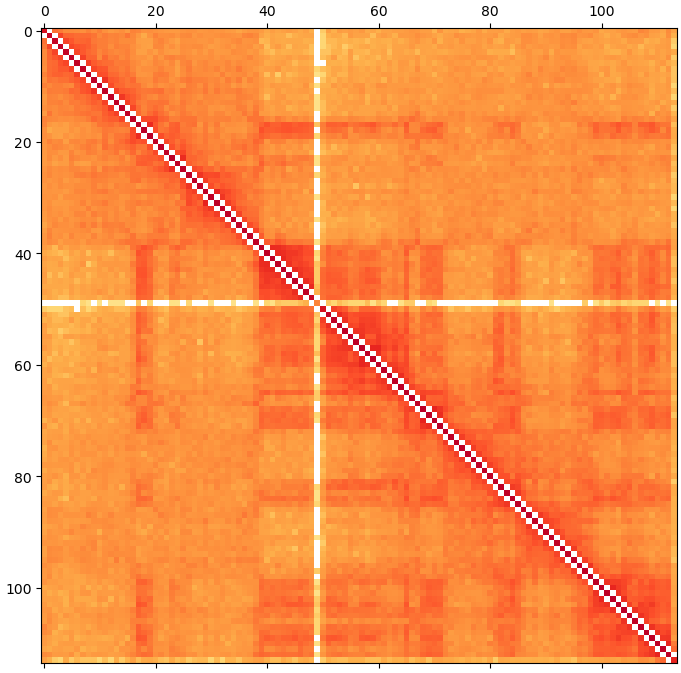

In [135]:
from matplotlib.colors import LogNorm

f, axs = plt.subplots(
    figsize=(7,7),
    ncols=1, nrows = 1)

im = axs.matshow(
    chrom19_normHiC_updatedWeights,
    cmap='YlOrRd',
    norm = LogNorm(vmax=10**4, vmin = 0.1)
)
ax.set_title("Raw value", y=1.08)
plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='balanced');

plt.tight_layout()
plt.show()